In [ ]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Style
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv('/content/cbc_anemia_dataset.csv')  # or your path if using Google Colab

df.head()


,WBC,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,Label
0,5.0,4.53,16.9,42.1,84.6,27.4,31.9,368.0,Normal
1,7.3,4.41,17.5,31.7,85.1,30.5,35.0,232.0,Normal
2,7.6,4.72,13.1,45.0,88.1,32.8,33.0,320.0,Normal
3,7.6,4.90,13.9,34.8,76.9,30.0,30.1,189.0,Normal
4,8.4,4.88,14.2,35.3,86.1,31.1,32.3,216.0,Normal


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WBC     1999 non-null   float64
 1   RBC     1999 non-null   float64
 2   HGB     1999 non-null   float64
 3   HCT     1999 non-null   float64
 4   MCV     1999 non-null   float64
 5   MCH     1999 non-null   float64
 6   MCHC    1999 non-null   float64
 7   PLT     1999 non-null   float64
 8   Label   1999 non-null   object 
dtypes: float64(8), object(1)
memory usage: 140.7+ KB


In [ ]:
# Check if any row contains a 0 value
rows_with_zeros = df[(df == 0).any(axis=1)]

# Print the rows containing 0 values
print(rows_with_zeros)

# Drop duplicates (if any)
df = df.drop_duplicates()

Empty DataFrame
Columns: [WBC, RBC, HGB, HCT, MCV, MCH, MCHC, PLT, Label]
Index: []


In [ ]:
# Stratify anemia severity based on Hemoglobin (HGB)
def stratify_severity(hgb):
    if hgb >= 13:
        return 0  # Normal
    elif 11 <= hgb < 13:
        return 1  # Mild
    elif 8 <= hgb < 11:
        return 2  # Moderate
    else:
        return 3  # Severe

df['Severity'] = df['HGB'].apply(stratify_severity)
df['Anemia'] = df['Severity'].apply(lambda x: 0 if x == 0 else 1)


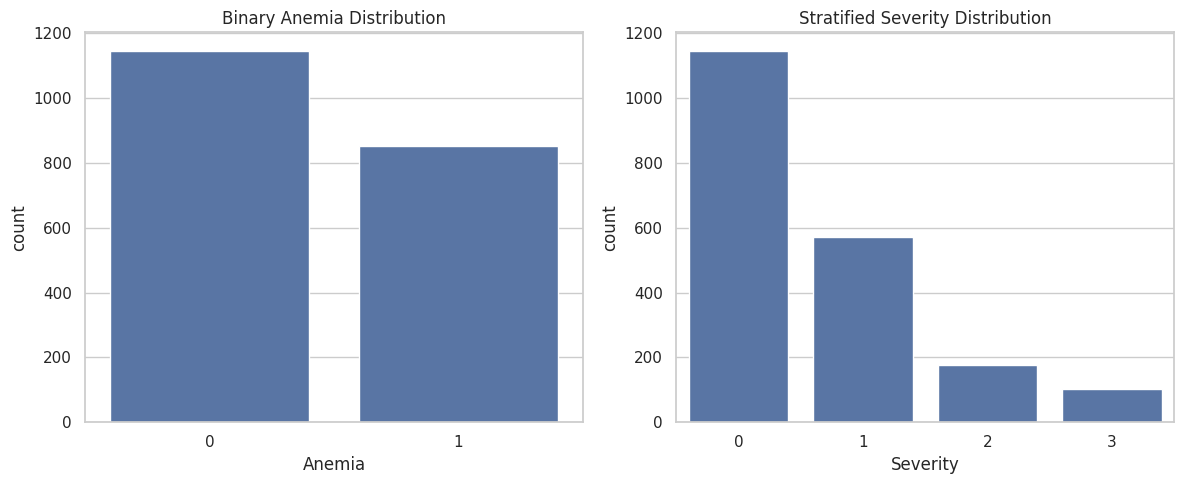

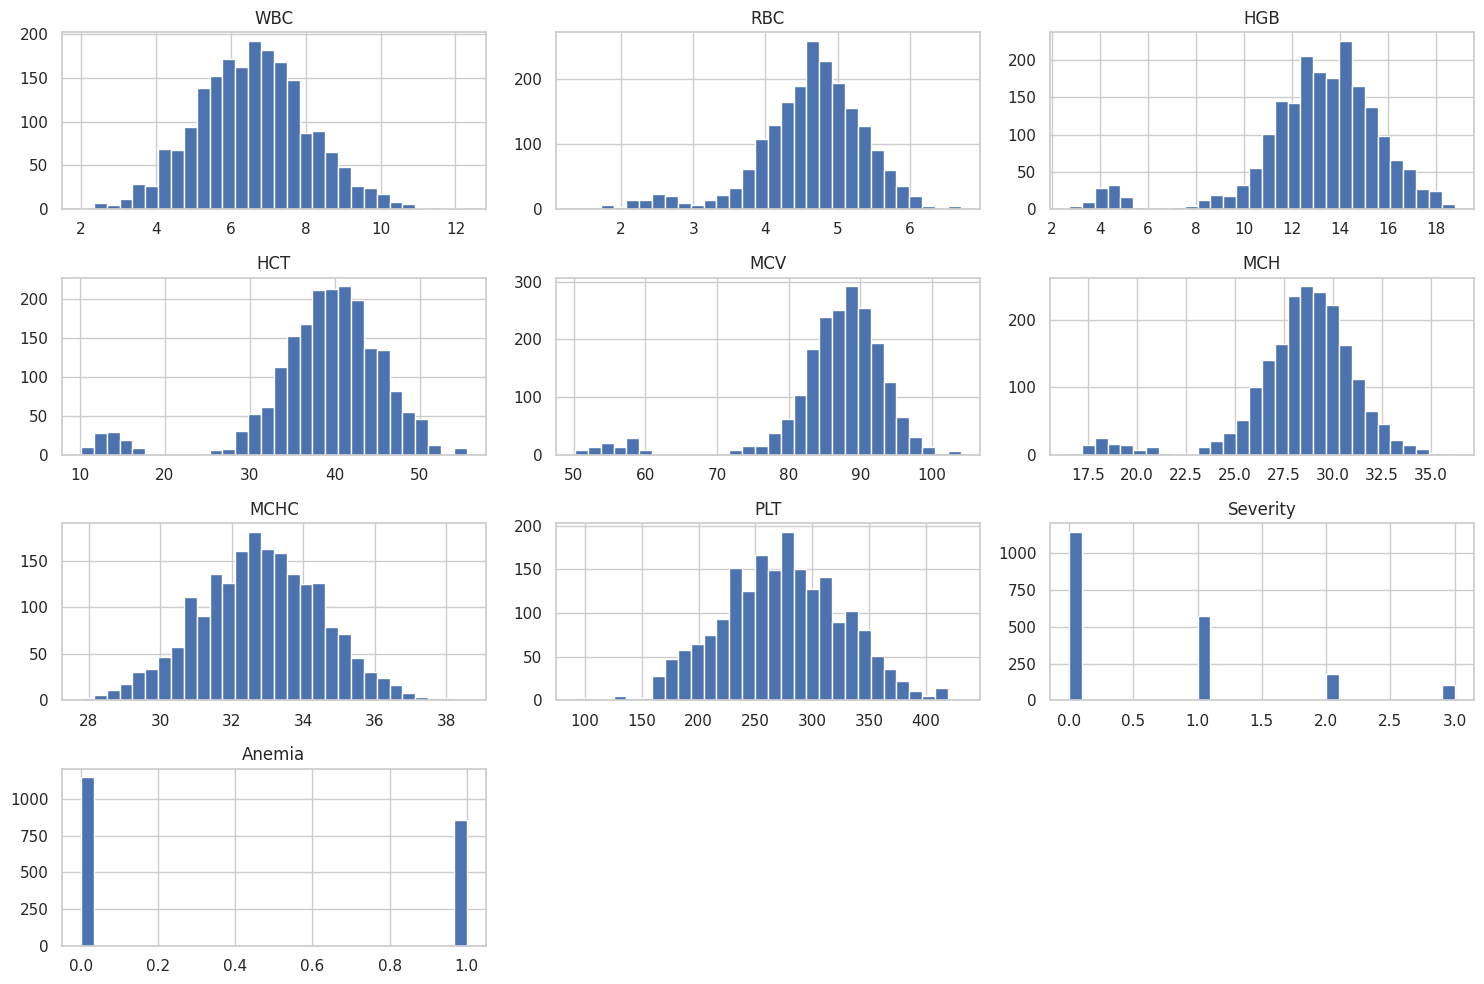

✅ Training Severity Distribution:
 Severity
0    688
1    343
2    106
3     62
Name: count, dtype: int64
✅ Testing Severity Distribution:
 Severity
0    229
1    115
2     36
3     20
Name: count, dtype: int64


In [ ]:
# Check class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Anemia', data=df)
plt.title('Binary Anemia Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='Severity', data=df)
plt.title('Stratified Severity Distribution')

plt.tight_layout()
plt.show()

# Check feature distributions
df.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

X = df.drop(columns=['Anemia', 'Severity'])
X = pd.get_dummies(X, drop_first=True)  # Encode categorical if present
y_binary = df['Anemia']
y_multi = df['Severity']

# First: split off test set (20%)
X_temp, X_test, yb_temp, yb_test, ym_temp, ym_test = train_test_split(
    X, y_binary, y_multi, test_size=0.2, stratify=y_multi, random_state=42
)

# Now split remaining 80% into train (60%) and validation (20%)
X_train, X_val, yb_train, yb_val, ym_train, ym_val = train_test_split(
    X_temp, yb_temp, ym_temp, test_size=0.25, stratify=ym_temp, random_state=42
)


# --- Step 4: Feature scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# --- Step 6: Confirm distribution ---
print("✅ Training Severity Distribution:\n", ym_train.value_counts())
print("✅ Testing Severity Distribution:\n", ym_test.value_counts())

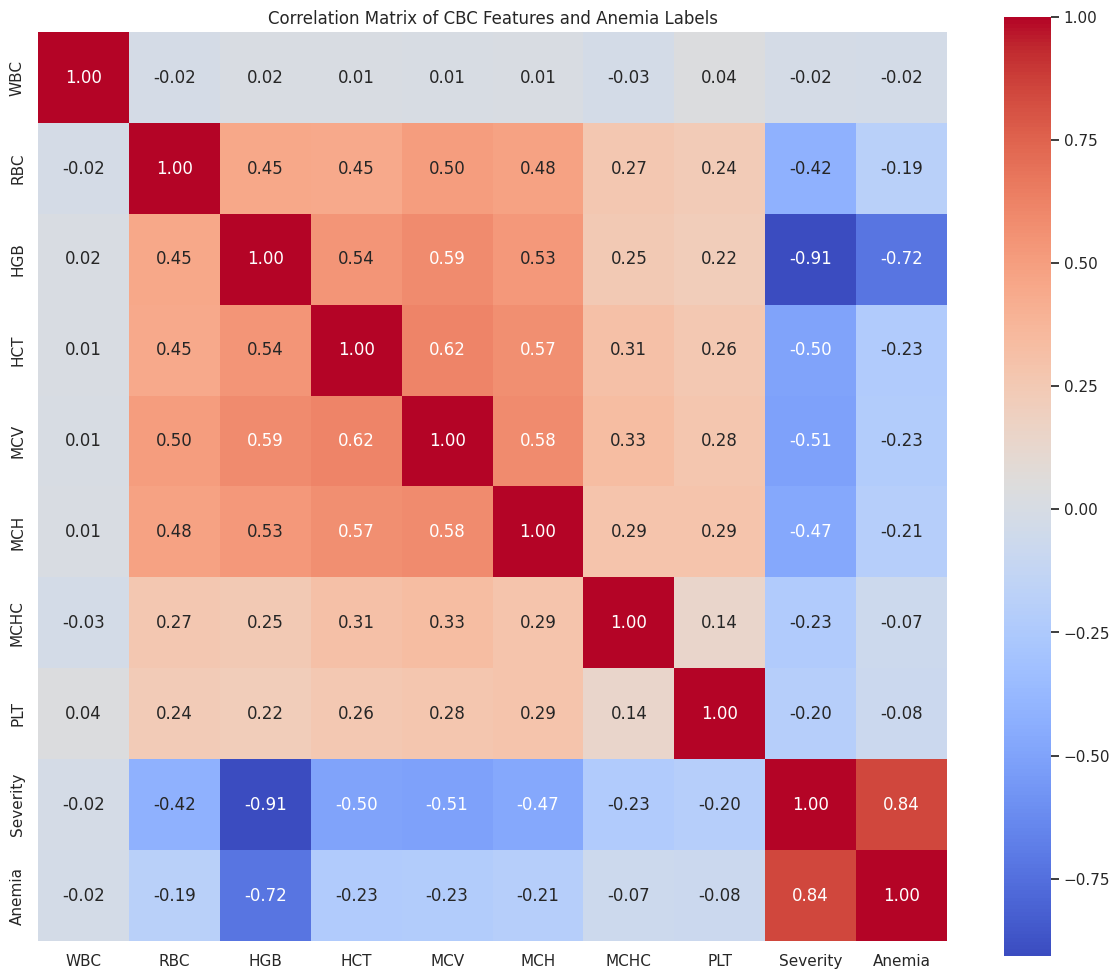

In [ ]:
# Compute correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of CBC Features and Anemia Labels')
plt.tight_layout()
plt.show()

Original Binary Class Distribution:
 Anemia
0    688
1    511
Name: count, dtype: int64
Original Multi-class Class Distribution:
 Severity
0    688
1    343
2    106
3     62
Name: count, dtype: int64


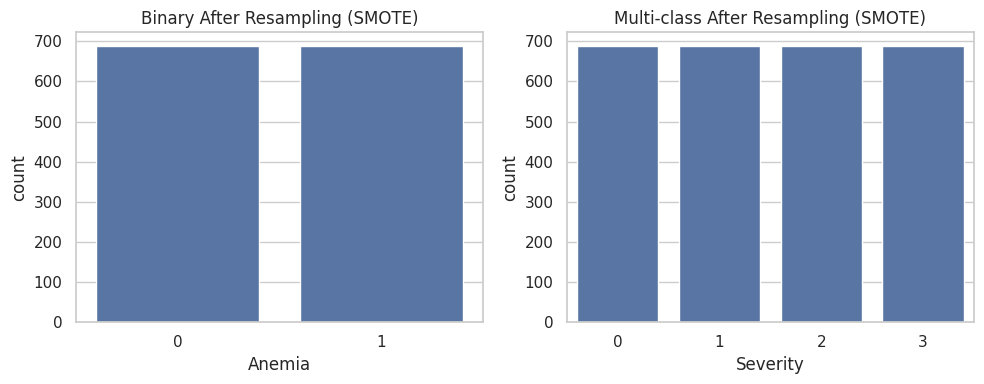

In [ ]:

# --- Step 1: Resample Binary Classification Data with SMOTE ---
print("Original Binary Class Distribution:\n", yb_train.value_counts())

min_samples_b = yb_train.value_counts().min()
safe_k_b = max(1, min(5, min_samples_b - 1))  # Ensure k_neighbors ≥ 1
smote_binary = SMOTE(random_state=42, k_neighbors=safe_k_b)

X_train_b_res, yb_train_res = smote_binary.fit_resample(X_train_scaled, yb_train)

# --- Step 2: Resample Multi-class Classification Data with SMOTE ---
print("Original Multi-class Class Distribution:\n", ym_train.value_counts())

min_samples_m = ym_train.value_counts().min()
safe_k_m = max(1, min(5, min_samples_m - 1))  # Ensure k_neighbors ≥ 1
smote_multi = SMOTE(random_state=42, k_neighbors=safe_k_m)

X_train_m_res, ym_train_res = smote_multi.fit_resample(X_train_scaled, ym_train)

# --- Step 3: Plot Class Distributions After SMOTE ---
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(x=yb_train_res.astype(str))
plt.title("Binary After Resampling (SMOTE)")

plt.subplot(1, 2, 2)
sns.countplot(x=ym_train_res.astype(str))
plt.title("Multi-class After Resampling (SMOTE)")

plt.tight_layout()
plt.show()

In [ ]:
# 🔍 Benchmarking Multiple Models (Before HistGradientBoosting)
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "HistGradientBoosting": HistGradientBoostingClassifier()
}

results_binary = {}
results_multi = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")

    # Train and evaluate on binary classification
    model.fit(X_train_b_res, yb_train_res)
    preds_b = model.predict(X_test_scaled)

    results_binary[name] = {
        "Accuracy": accuracy_score(yb_test, preds_b),
        "Precision": precision_score(yb_test, preds_b),
        "Recall": recall_score(yb_test, preds_b),
        "F1": f1_score(yb_test, preds_b)
    }

    # Train and evaluate on multi-class classification
    model.fit(X_train_m_res, ym_train_res)
    preds_m = model.predict(X_test_scaled)

    results_multi[name] = {
        "Accuracy": accuracy_score(ym_test, preds_m),
        "Precision": precision_score(ym_test, preds_m, average='weighted'),
        "Recall": recall_score(ym_test, preds_m, average='weighted'),
        "F1": f1_score(ym_test, preds_m, average='weighted')
    }

print("\n📊 Binary Classification Results:")
print(pd.DataFrame(results_binary).T.sort_values(by="F1", ascending=False))

print("\n📊 Multi-Class Classification Results:")
print(pd.DataFrame(results_multi).T.sort_values(by="F1", ascending=False))



🔹 Training Random Forest...

🔹 Training Logistic Regression...

🔹 Training SVM...

🔹 Training KNN...

🔹 Training Gradient Boosting...

🔹 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:55:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  msg += " or "
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:55:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  msg += " or "



🔹 Training HistGradientBoosting...

📊 Binary Classification Results:
                      Accuracy  Precision    Recall        F1
Random Forest           1.0000   1.000000  1.000000  1.000000
XGBoost                 1.0000   1.000000  1.000000  1.000000
Gradient Boosting       1.0000   1.000000  1.000000  1.000000
HistGradientBoosting    0.9975   1.000000  0.994152  0.997067
Logistic Regression     0.9875   0.988235  0.982456  0.985337
SVM                     0.9725   0.981928  0.953216  0.967359
KNN                     0.8650   0.882353  0.789474  0.833333

📊 Multi-Class Classification Results:
                      Accuracy  Precision  Recall        F1
XGBoost                 1.0000   1.000000  1.0000  1.000000
Gradient Boosting       0.9975   0.997568  0.9975  0.997485
Random Forest           0.9975   0.997568  0.9975  0.997485
HistGradientBoosting    0.9900   0.989939  0.9900  0.989950
Logistic Regression     0.9700   0.974367  0.9700  0.970582
SVM                     0.9350   0.

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters for Binary Logistic Regression with Reduced Complexity: {'l1_ratio': np.float64(0.38888888888888884), 'C': np.float64(0.1)}

📘 Binary Classification Report (Anemia Detection) - ElasticNet Reduced Complexity:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       140
      Anemia       0.98      0.99      0.99       136

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



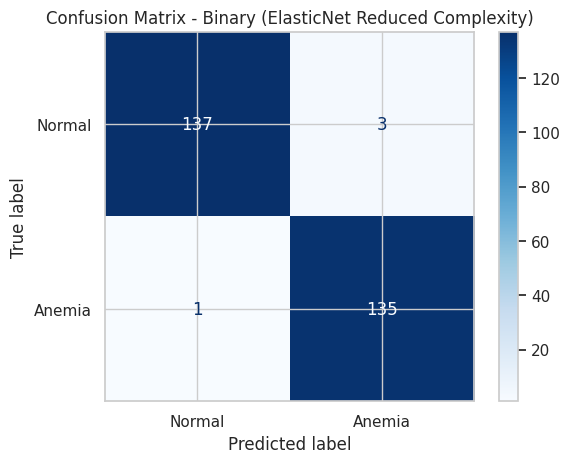

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Split data into train and validation set
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_b_res, yb_train_res, test_size=0.2, random_state=42)

# Define Logistic Regression Model for Binary Classification using ElasticNet
logreg_binary = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    random_state=42,
    max_iter=10000
)

# --- Step 1: Hyperparameter Tuning with Reduced Complexity ---
param_dist_logreg = {
    'C': np.logspace(-4, -1, 20),           # Stronger regularization
    'l1_ratio': np.linspace(0, 0.5, 10),    # Favor more L2 (less L1)
}

# Setup RandomizedSearchCV
random_search_logreg = RandomizedSearchCV(
    estimator=logreg_binary,
    param_distributions=param_dist_logreg,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Train using RandomizedSearchCV
random_search_logreg.fit(X_train_b, y_train_b)

# Get the best model
best_logreg_binary = random_search_logreg.best_estimator_

print("Best Hyperparameters for Binary Logistic Regression with Reduced Complexity:", random_search_logreg.best_params_)

# --- Step 2: Evaluate the Tuned Model ---
binary_preds = best_logreg_binary.predict(X_val_b)
print("\n📘 Binary Classification Report (Anemia Detection) - ElasticNet Reduced Complexity:")
print(classification_report(y_val_b, binary_preds, target_names=["Normal", "Anemia"]))

# Confusion Matrix
cm_b = confusion_matrix(y_val_b, binary_preds)
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=["Normal", "Anemia"])
disp_b.plot(cmap="Blues")
plt.title("Confusion Matrix - Binary (ElasticNet Reduced Complexity)")
plt.show()


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       229
        Mild       0.99      0.99      0.99       115
    Moderate       0.92      0.97      0.95        36
      Severe       1.00      0.85      0.92        20

    accuracy                           0.99       400
   macro avg       0.98      0.95      0.96       400
weighted avg       0.99      0.99      0.99       400



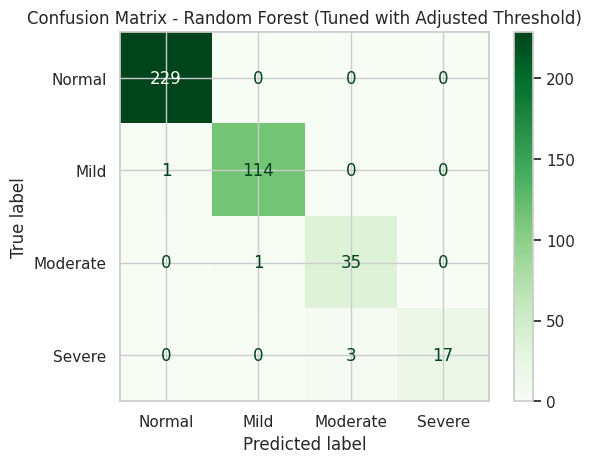

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# --- Stratified CV for better generalization ---
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Base model for Random Forest Classifier ---
rf_model = RandomForestClassifier(
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1  # Use all available CPUs
)

# --- Hyperparameter Grid for RandomizedSearchCV ---
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when splitting a node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# --- Randomized Search with Cross-Validation ---
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=30,  # Number of random combinations to try
    scoring='accuracy',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# --- Train the model ---
random_search_rf.fit(X_train_m_res, ym_train_res)
best_rf_model = random_search_rf.best_estimator_

# --- Evaluate the model ---
rf_preds = best_rf_model.predict(X_test_scaled)

# Adjusting the threshold for predicting Severe class (class index 3)
probs = best_rf_model.predict_proba(X_test_scaled)
threshold = 0.3  # Lower threshold for Severe class (class 3)
rf_preds_adjusted = np.argmax(probs >= threshold, axis=1)

# Show Best Hyperparameters from RandomizedSearchCV
print("Best Hyperparameters:", random_search_rf.best_params_)

# --- Classification Report ---
print(classification_report(
    ym_test, rf_preds_adjusted, labels=[0, 1, 2, 3],
    target_names=["Normal", "Mild", "Moderate", "Severe"],
    zero_division=0
))

# --- Confusion Matrix ---
cm_rf = confusion_matrix(ym_test, rf_preds_adjusted, labels=[0, 1, 2, 3])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Normal", "Mild", "Moderate", "Severe"])
disp_rf.plot(cmap="Greens")
plt.title("Confusion Matrix - Random Forest (Tuned with Adjusted Threshold)")
plt.show()

In [ ]:
def predict_severity():
    try:
        expected_columns = X.columns.tolist()
        print("Please enter the following information:")

        # Prompt user for numeric input
        features = {}
        features['WBC'] = float(input("Enter WBC (e.g., White Blood Cell count): "))
        features['RBC'] = float(input("Enter RBC (e.g., Red Blood Cell count): "))
        features['HGB'] = float(input("Enter HGB (e.g., Hemoglobin level): "))
        features['HCT'] = float(input("Enter HCT (e.g., Hematocrit level): "))
        features['MCV'] = float(input("Enter MCV (e.g., Mean Corpuscular Volume): "))
        features['MCH'] = float(input("Enter MCH (e.g., Mean Corpuscular Hemoglobin): "))
        features['MCHC'] = float(input("Enter MCHC (e.g., Mean Corpuscular Hemoglobin Concentration): "))
        features['PLT'] = float(input("Enter PLT (e.g., Platelet count): "))

        # Create DataFrame
        user_input = pd.DataFrame([features])

        # No categorical variables, so no get_dummies needed
        user_input_encoded = user_input.copy()

        # Ensure all expected columns are present (from training)
        for col in expected_columns:
            if col not in user_input_encoded.columns:
                user_input_encoded[col] = 0  # Add missing column with 0

        # Reorder columns
        user_input_encoded = user_input_encoded[expected_columns]

        # Scale the input just like training data
        user_input_scaled = scaler.transform(user_input_encoded)

        # Predict with trained Random Forest model
        severity_prediction = best_rf_model.predict(user_input_scaled)[0]

        # Class label mapping
        severity_map = {0: "Normal", 1: "Mild", 2: "Moderate", 3: "Severe"}
        predicted_severity = severity_map.get(severity_prediction, "Unknown")

        print(f"\nPredicted Severity: {predicted_severity}")

    except NameError as e:
        print("Missing required object. Make sure the following are defined: 'expected_columns', 'scaler', and 'best_rf_model'.")
        print("Details:", e)
    except Exception as e:
        print("An error occurred during prediction:")
        print(e)

predict_severity()


Please enter the following information:
Enter WBC (e.g., White Blood Cell count): 6.0
Enter RBC (e.g., Red Blood Cell count): 5.0
Enter HGB (e.g., Hemoglobin level): 15.0
Enter HCT (e.g., Hematocrit level): 45.0
Enter MCV (e.g., Mean Corpuscular Volume): 90.0
Enter MCH (e.g., Mean Corpuscular Hemoglobin): 30.0
Enter MCHC (e.g., Mean Corpuscular Hemoglobin Concentration): 33.0
Enter PLT (e.g., Platelet count): 250

Predicted Severity: Normal


In [ ]:
predict_severity()

Please enter the following information:
Enter WBC (e.g., White Blood Cell count): 7.5
Enter RBC (e.g., Red Blood Cell count): 4.73
Enter HGB (e.g., Hemoglobin level): 11.9
Enter HCT (e.g., Hematocrit level): 37.9
Enter MCV (e.g., Mean Corpuscular Volume): 88.1
Enter MCH (e.g., Mean Corpuscular Hemoglobin): 25.4
Enter MCHC (e.g., Mean Corpuscular Hemoglobin Concentration): 31.6
Enter PLT (e.g., Platelet count): 311

Predicted Severity: Mild


In [ ]:
predict_severity()

Please enter the following information:
Enter WBC (e.g., White Blood Cell count): 6.0
Enter RBC (e.g., Red Blood Cell count): 4.2
Enter HGB (e.g., Hemoglobin level): 9.5
Enter HCT (e.g., Hematocrit level): 32.0
Enter MCV (e.g., Mean Corpuscular Volume): 76
Enter MCH (e.g., Mean Corpuscular Hemoglobin): 24.5
Enter MCHC (e.g., Mean Corpuscular Hemoglobin Concentration): 31.5
Enter PLT (e.g., Platelet count): 250

Predicted Severity: Moderate


In [ ]:
predict_severity()

Please enter the following information:
Enter WBC (e.g., White Blood Cell count): 5.5
Enter RBC (e.g., Red Blood Cell count): 3.8
Enter HGB (e.g., Hemoglobin level): 3.5
Enter HCT (e.g., Hematocrit level): 26.0
Enter MCV (e.g., Mean Corpuscular Volume): 68
Enter MCH (e.g., Mean Corpuscular Hemoglobin): 21.0
Enter MCHC (e.g., Mean Corpuscular Hemoglobin Concentration): 30.0
Enter PLT (e.g., Platelet count): 310

Predicted Severity: Severe
